# 기본 설정 + 데이터 생성 (2차원)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

# --- 데이터 선택: 'blobs' or 'moons' ---
DATASET = 'blobs'  # 'moons'로 바꿔도 됨

if DATASET == 'blobs':
    X, y = make_blobs(n_samples=600, n_features=2, centers=4, cluster_std=1.2, random_state=0)
else:
    X, y = make_moons(n_samples=600, noise=0.25, random_state=42)

# 학습/검증 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# 스케일링 (KNN은 거리 기반 → 스케일링 중요)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

print(X_train.shape, X_test.shape, np.bincount(y_train), np.bincount(y_test))



(450, 2) (150, 2) [112 113 112 113] [38 37 38 37]


Input Parameter

n_samples : 표본 데이터의 수, 디폴트 100

n_features : 독립 변수의 수, 디폴트 20

centers : 생성할 클러스터의 수 혹은 중심, [n_centers, n_features] 크기의 배열. 디폴트 3

cluster_std: 클러스터의 표준 편차, 디폴트 1.0

center_box: 생성할 클러스터의 바운딩 박스(bounding box), 디폴트 (-10.0, 10.0))

shuffle: TRUE하면 숫자를 랜덤으로 섞어주는 역할을 한다.



Return Parameter:

X : [n_samples, n_features] 크기의 배열: 독립 변수

y : [n_samples] 크기의 배열: 종속 변수

# KNN 직접 구현 (거리함수/다수결/가중투표/동률-최단거리 우선)

In [ ]:
from collections import Counter

def pairwise_distance(a: np.ndarray, b: np.ndarray, metric='euclidean'):
    """
    a: (N, d), b: (M, d)
    return: (N, M) distance matrix
    """
    if metric == 'euclidean':
        # (x - y)^2 = x^2 + y^2 - 2xy
        a2 = np.sum(a**2, axis=1, keepdims=True)        # (N,1)
        b2 = np.sum(b**2, axis=1, keepdims=True).T      # (1,M)
        d2 = a2 + b2 - 2 * a @ b.T                      # (N,M)
        d2 = np.maximum(d2, 0.0)
        return np.sqrt(d2)
    elif metric == 'manhattan':
        # 방송 연산으로 L1
        return np.sum(np.abs(a[:, None, :] - b[None, :, :]), axis=2)
    else:
        raise ValueError("metric must be 'euclidean' or 'manhattan'")

class KNNClassifier:
    def __init__(self, k, metric='euclidean', weighted=False):
        """
        k: 최근접 이웃 수
        metric: 'euclidean' | 'manhattan'
        weighted: True면 거리 역수 가중치(1/(d+eps))로 투표
        """
        self.k = k
        self.metric = metric
        self.weighted = weighted
        self.X = None
        self.y = None

    def fit(self, X, y):
        self.X = np.asarray(X, dtype=float)
        self.y = np.asarray(y)

    def _vote(self, neighbor_labels, neighbor_dists):
        if not self.weighted:
            # 다수결
            counts = Counter(neighbor_labels)
            # 동률이면: 해당 라벨들 중 총거리 합이 가장 작은 라벨 선택
            max_cnt = max(counts.values())
            tied = [lbl for lbl, c in counts.items() if c == max_cnt]
            if len(tied) == 1:
                return tied[0]
            # tie-break: 총거리 합 최소 라벨
            best_lbl, best_sum = None, float('inf')
            for lbl in tied:
                s = np.sum(neighbor_dists[neighbor_labels == lbl])
                if s < best_sum:
                    best_lbl, best_sum = lbl, s
            return best_lbl
        else:
            # 거리 역수 가중치
            eps = 1e-9
            weights = 1.0 / (neighbor_dists + eps)
            # 라벨별 가중합
            uniq = np.unique(neighbor_labels)
            best_lbl, best_w = None, -1.0
            for lbl in uniq:
                w = np.sum(weights[neighbor_labels == lbl])
                if w > best_w:
                    best_lbl, best_w = lbl, w
            return best_lbl

    def predict(self, Xq):
        Xq = np.asarray(Xq, dtype=float)
        D = pairwise_distance(Xq, self.X, metric=self.metric)   # (nq, ntrain)
        idx_sorted = np.argsort(D, axis=1)[:, :self.k]          # (nq, k)
        neighbors_y = self.y[idx_sorted]                        # (nq, k)
        neighbors_d = np.take_along_axis(D, idx_sorted, axis=1) # (nq, k)
        # 각 질의에 대해 투표
        preds = []
        for i in range(Xq.shape[0]):
            preds.append(self._vote(neighbors_y[i], neighbors_d[i]))
        return np.array(preds)

    def neighbors(self, xq):
        """ 단일 점 xq에 대한 k-NN 인덱스/거리 반환 (시각화용) """
        xq = np.asarray(xq, dtype=float)[None, :]
        d = pairwise_distance(xq, self.X, metric=self.metric)[0]  # (ntrain,)
        idx = np.argsort(d)[:self.k]
        return idx, d[idx]


# 학습/평가 + 예제 질의점(neighbors) 시각화

[KNN] k=7, metric=euclidean, weighted=True → Test Acc = 0.8800


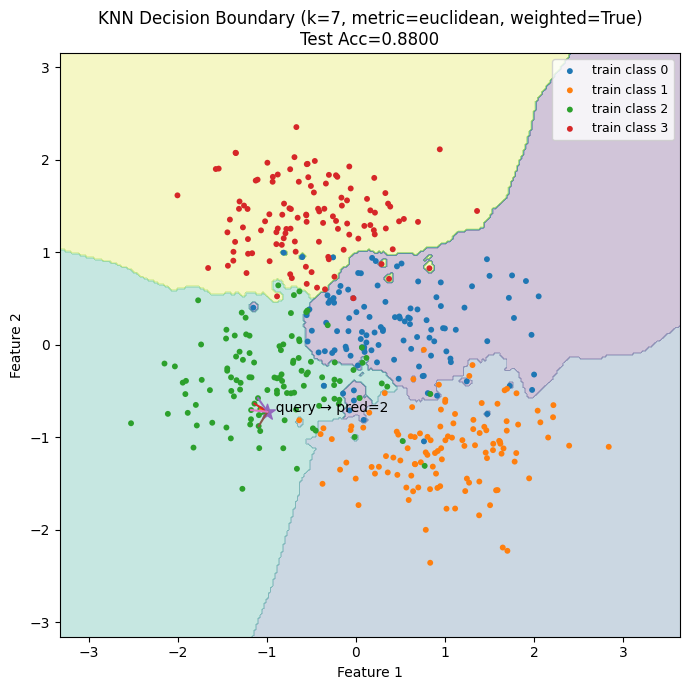

In [ ]:
# 하이퍼파라미터
k = 7
metric = 'euclidean'  # 'manhattan'도 테스트 가능
weighted = True       # 가중투표(1/d)

knn = KNNClassifier(k=k, metric=metric, weighted=weighted)
knn.fit(X_train, y_train)

# 정확도
y_pred = knn.predict(X_test)
acc = (y_pred == y_test).mean()
print(f"[KNN] k={k}, metric={metric}, weighted={weighted} → Test Acc = {acc:.4f}")

# 시각화용: 결정경계 + 훈련데이터 + 예제 질의점/이웃
fig = plt.figure(figsize=(7, 7))

# 메쉬 그리드
x_min, x_max = X_train[:,0].min()-0.8, X_train[:,0].max()+0.8
y_min, y_max = X_train[:,1].min()-0.8, X_train[:,1].max()+0.8
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
zz = knn.predict(grid).reshape(xx.shape)

# 결정경계(채움)
plt.contourf(xx, yy, zz, alpha=0.25)

# 학습 데이터 산점도
for cls in np.unique(y_train):
    pts = X_train[y_train == cls]
    plt.scatter(pts[:,0], pts[:,1], label=f"train class {cls}", s=18, edgecolors='none')

# 예제 질의점 하나 골라 보기
xq = X_test[3]
pred_q = knn.predict([xq])[0]
idx_knn, d_knn = knn.neighbors(xq)
nbrs = X_train[idx_knn]
labels_nbrs = y_train[idx_knn]

# 질의점
plt.scatter([xq[0]], [xq[1]], s=140, marker='*')
plt.text(xq[0], xq[1], f"  query → pred={pred_q}", fontsize=10)

# 질의점과 이웃들을 선으로 연결
for p, lbl in zip(nbrs, labels_nbrs):
    plt.plot([xq[0], p[0]], [xq[1], p[1]])

plt.title(f"KNN Decision Boundary (k={k}, metric={metric}, weighted={weighted})\nTest Acc={acc:.4f}")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.show()
